# SmartCampaingBase 

Basic campaign which allows change alpha and campaign risk adjustment metrics, but doesn't support alpha rebalancing / weighting.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Smart campaign definition

In [27]:
CAMPAIGN_DICT = {
    'name': "BasicSmartCampaign",
    
    # Allowed values for both ALPHA_RISK_TYPE and CAMPAIGN_RISK_TYPE

    # 'atr' - ATR(RISK_PERIOD) of alpha/campaign equity risk metric
    # 'atrmax' - Highest(ATR(RISK_PERIOD)) of alpha/campaign equity risk metric
    # 'ddavg' - rolling mean (RISK_PERIOD) of drawdown of alpha/campaign equity 
    # 'ddmax' - rolling maximum (RISK_PERIOD) of drawdown of alpha/campaign equity
    # 'ddq95' - rolling 95% quantile (RISK_PERIOD) of drawdown of alpha/campaign equity    
    'alpha_risk_type': 'atr',
    'alpha_risk_period': 100,
    'alpha_min_risk': 100,

    'campaign_risk_type': 'atrmax',
    'campaign_risk_period': 100,
    'campaign_min_risk': 100,
    
    #
    # Campaign definition
    #
    'alphas': {
        '!NEW_AlphaV1Exposure_HedgedBy_V2_IndexEXOLongEnhance_DT_PutSpread_DSP_InstaTrendline__Bullish_Aug_7_33': {'tag': 'long', 'product': 'CL'},
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_CL_EXO_PutSpread_DynKel_longs_DSP_LowPass__Bullish_Aug_29_18': {'tag': 'long', 'product': 'CL'},
        '!NEW_NEW_AlphaV1Exposure_HedgedBy_V2_IndexCL_EXOLongEnhance_DT_PutSpread_DSP_LPBP_Combination__Bullish_32_Sept_21_63': {'tag': 'long', 'product': 'CL'},
        
        ##!! Risk reversal stack V1 + V2
        'CL_ContFut_Long_Strategy_DSP_InstaTrendline__Bullish_Aug_7_custom_hedged':
        {
            'tag': 'long',  # <- tagging!
            'alphas': {
                'CL_ContFut_Long_Strategy_DSP_InstaTrendline__Bullish_Aug_7_custom': 1.0,
                '!NEW_AlphaV1Exposure_HedgedBy_V2_US_CL_EXOSemiFuture_DynKel_20_80_longs_for_DSP_InstaTrendline__Bullish_Aug_7_33' :1.0,  
            }
             },
        
        'CL_ContFut_Long_Strategy_DSP_LowPass__Bullish_Aug_29_custom_hedged':
        {
            'tag': 'long',  # <- tagging!
            'alphas': {
                'CL_ContFut_Long_Strategy_DSP_LowPass__Bullish_Aug_29_custom': 1.0,
                '!NEW_AlphaV1Exposure_HedgedBy_V2_US_CL_EXOSemiFuture_DynKel_20_60_longs_for_DSP_LowPass__Bullish_Aug_29_33' :1.0,  
            }
        },
    }
}

### Loading smart campaign alphas

In [28]:
import pandas as pd
from smartcampaign import SmartCampaignBase
from smartcampaign.tools import *
import os

#
# Init V1 framework datasource
#
from exobuilder.data.exostorage import EXOStorage
from scripts.settings import *

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)



# Loading V1 and V2 alphas
alphas_list = SmartCampaignBase.get_alphas_list_from_settings(CAMPAIGN_DICT)
alphas_series_dict = storage.swarms_data(alphas_list, load_v2_alphas=True)
df_alphas_equities = {k: v['swarm_series'] for k,v in alphas_series_dict.items()}


# Backtesting

In [29]:
#
# Init Smart Campaign
#
scmp = SmartCampaignBase(CAMPAIGN_DICT, df_alphas_equities)

BACKTESTER_SETTINGS = {
    'start_date': datetime.datetime(2014, 1, 1),
    'initial_capital': 50000,
    'target_risk_percent': 0.01,    
}

bt_dict = scmp.backtest(**BACKTESTER_SETTINGS)

                                 MM             Adj Plain      Adj No Reinv   Simple Sum  
NetProfit $                          10899.48       10899.48       11754.20        2065.18
NetProfit %                            21.80%         21.80%         23.51%          4.13%

MaxDD $                             -22342.55      -22342.55      -24137.22      -51520.10
MaxDD %                               -39.84%        -39.84%        -43.16%        -78.16%

MaxATR $                               441.82         441.82         558.95         873.65
Q95% ATR $                             421.51         421.51         493.94         805.35
Avg ATR $                              306.52         306.52         353.77         682.96

MaxATR %                                1.15%          1.15%          1.41%          5.41%
Q95% ATR %                              1.01%          1.01%          1.21%          3.64%
Avg ATR %                               0.72%          0.72%          0.84%          2.

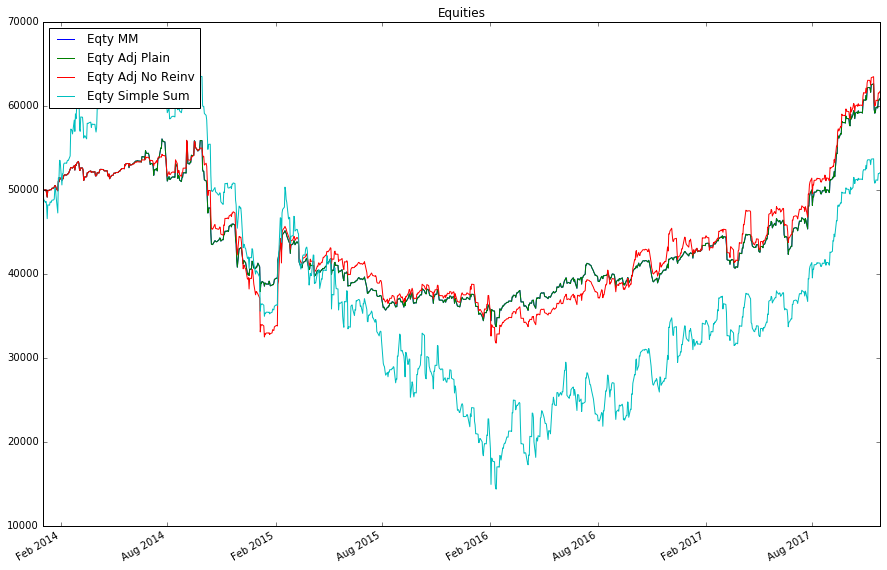

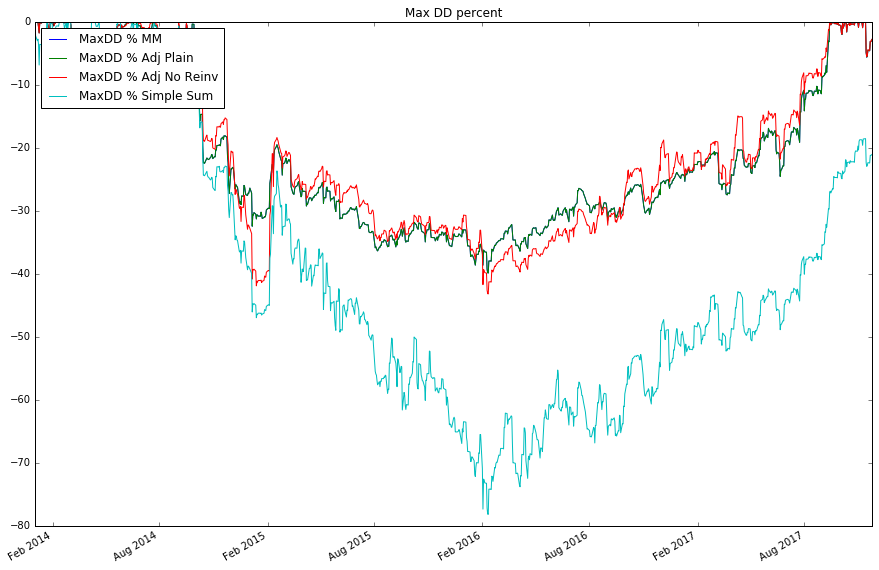

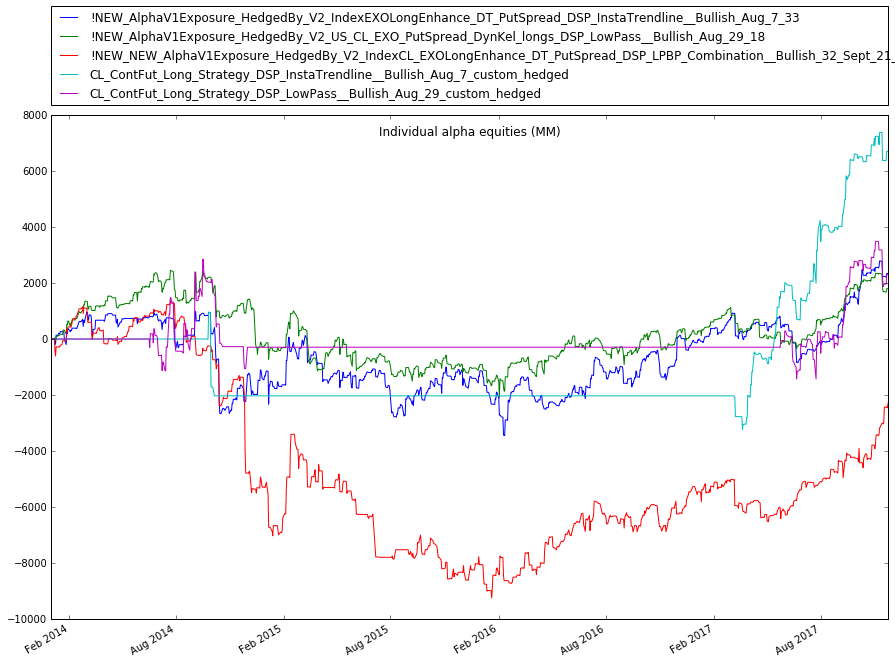

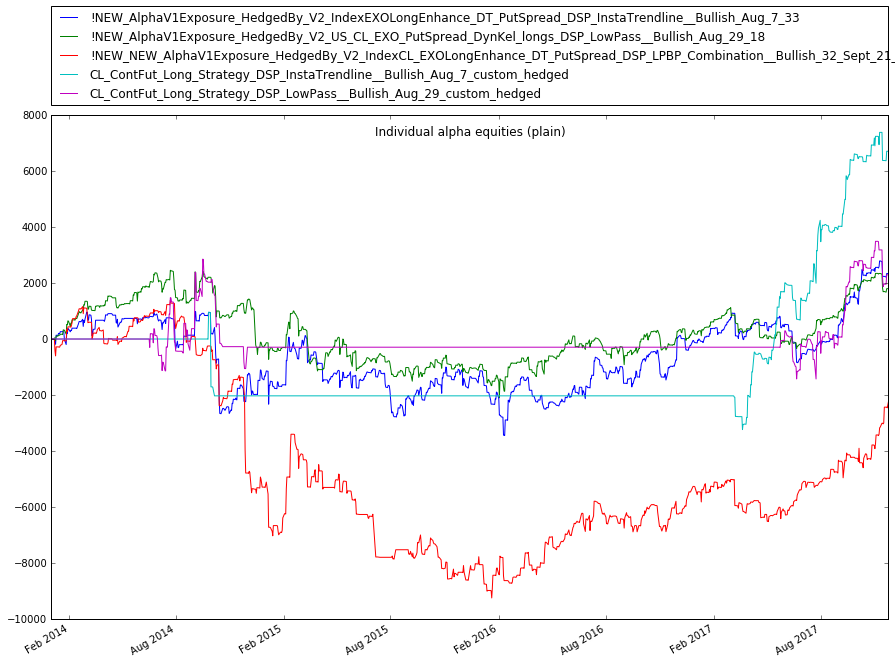

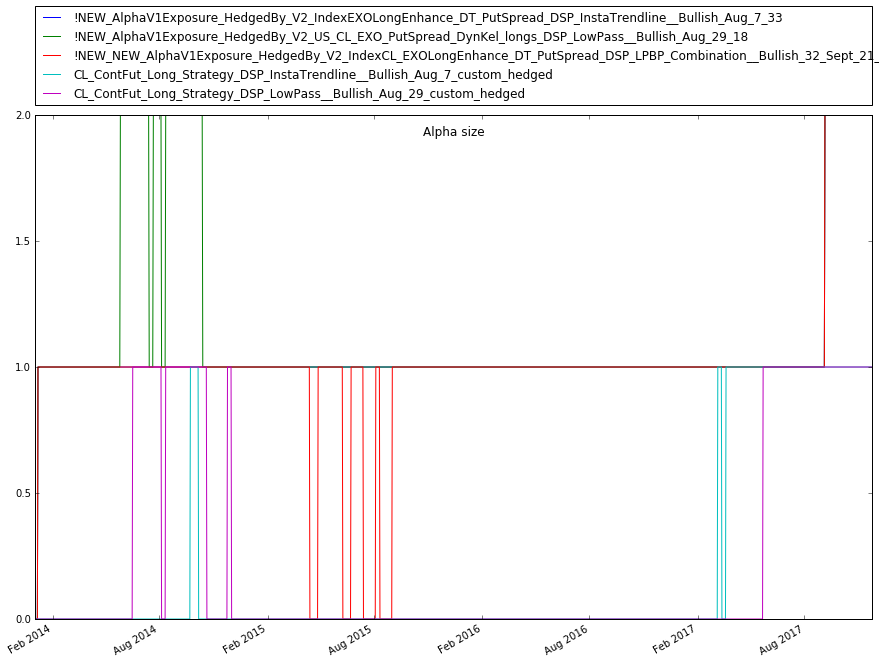

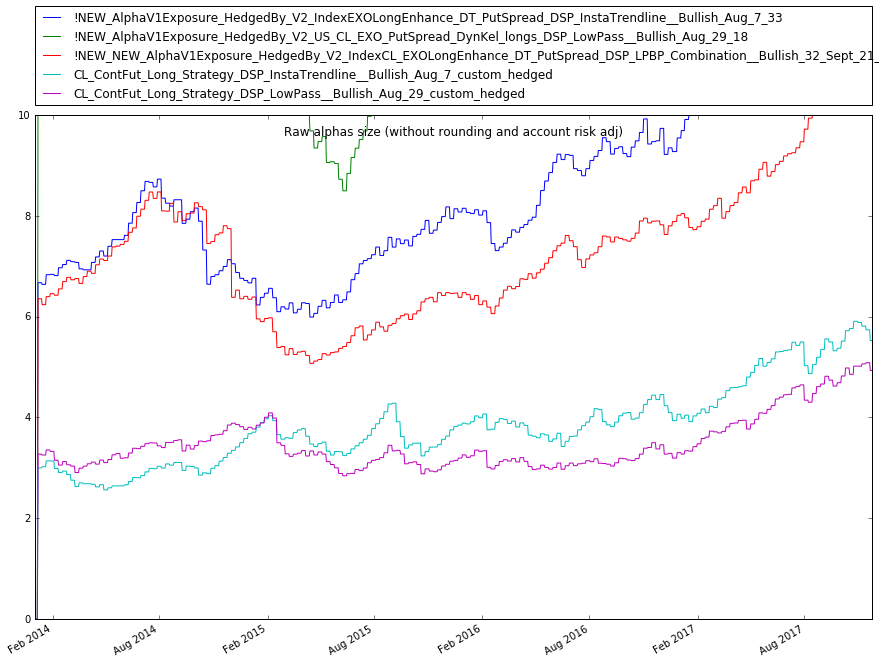

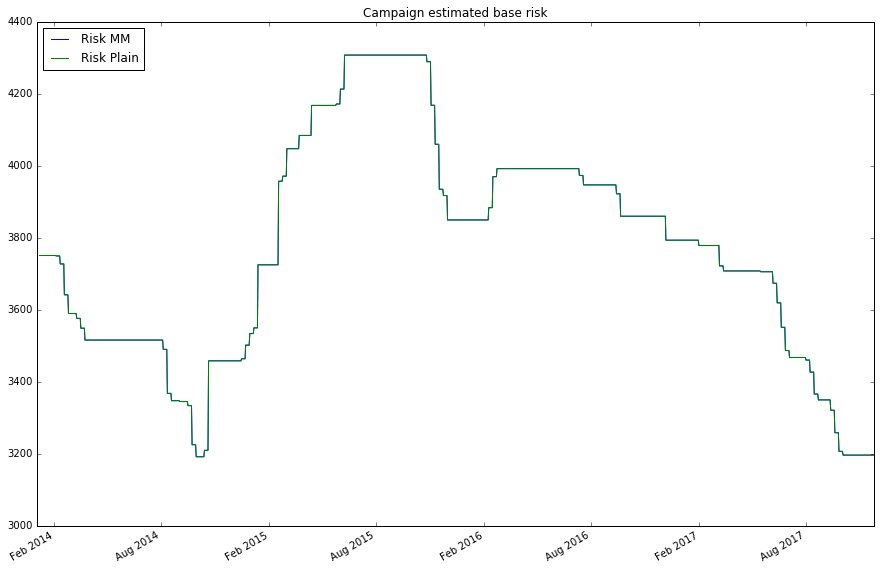

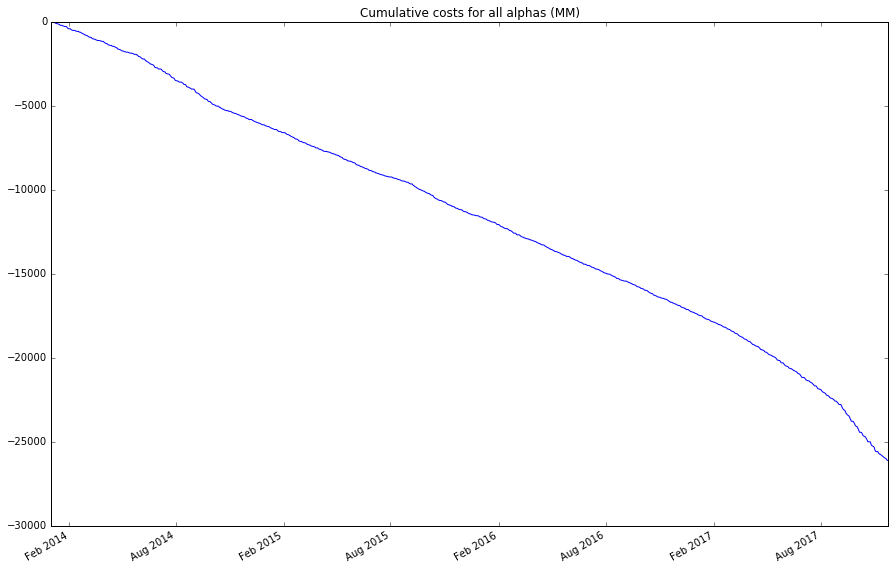

In [30]:
figsize(15, 10)
scmp.report(bt_dict)

## Execution related report

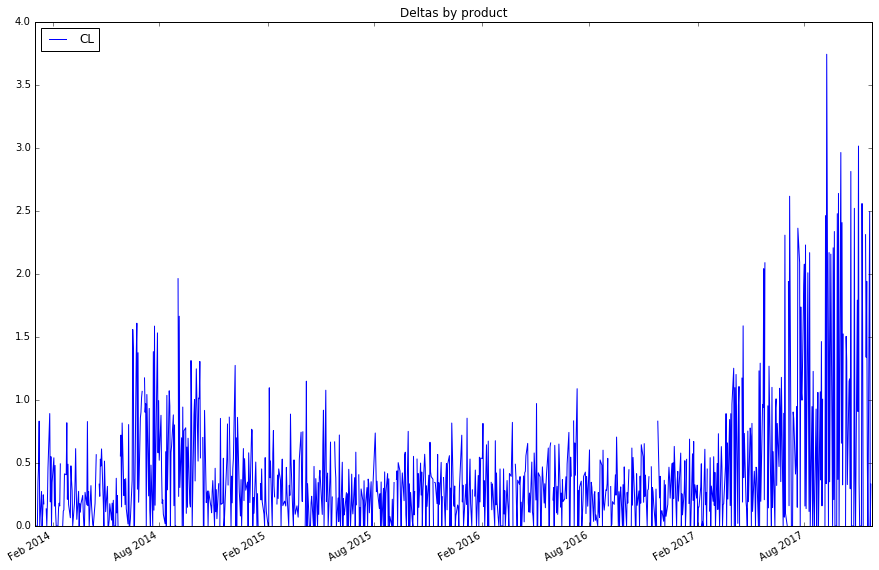

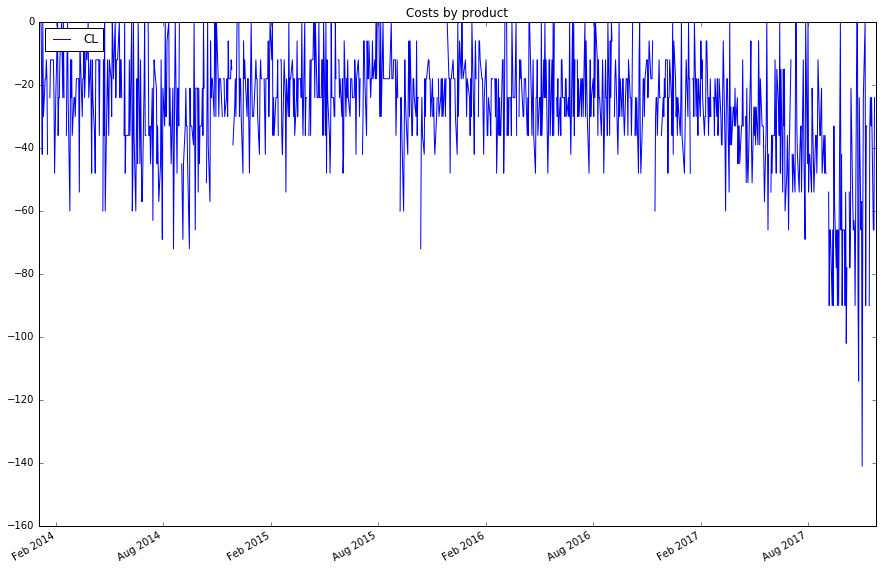

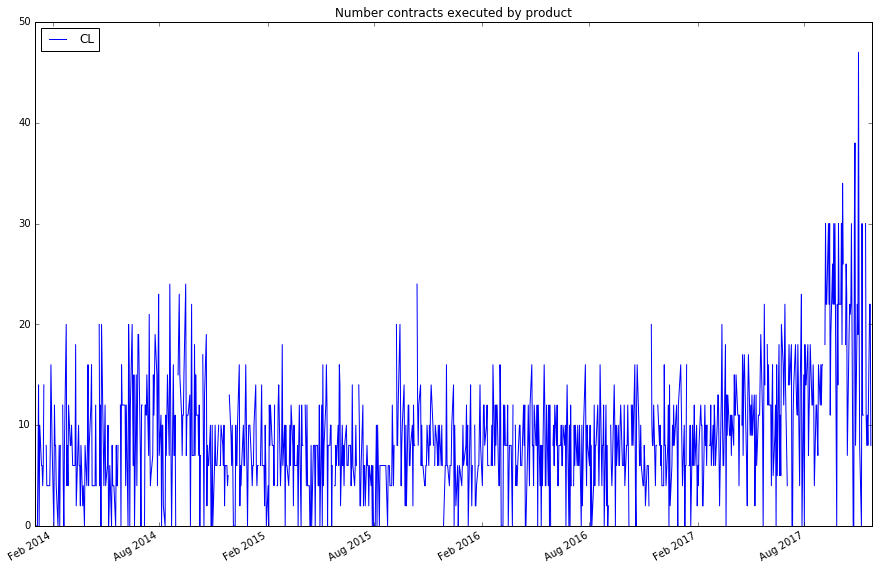

In [31]:
scmp.report_execution_info(bt_dict)

# Money management report

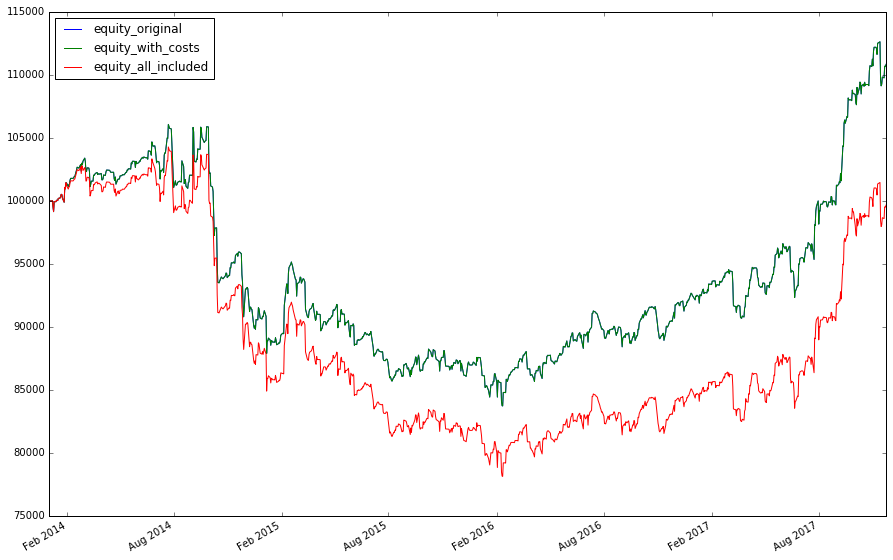

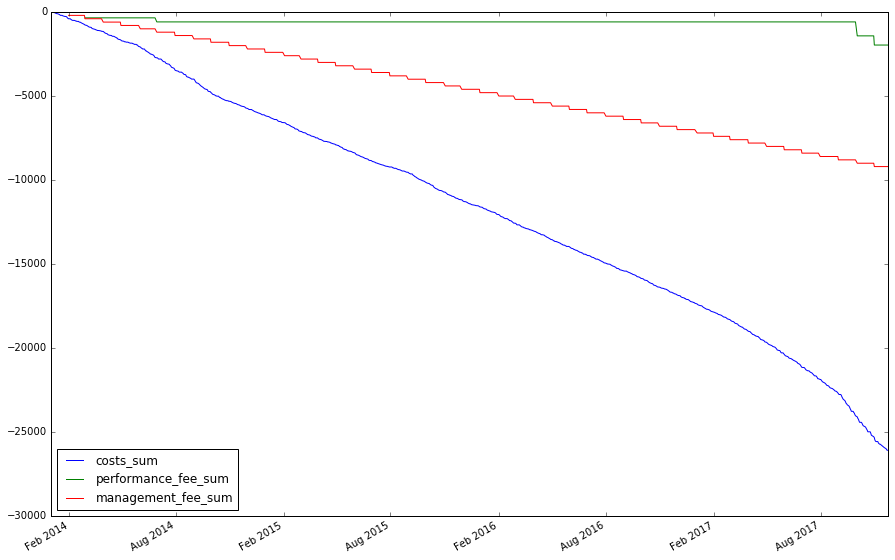

In [32]:
mm_report_data = scmp.report_money_management(bt_dict, 
                                              alt_dollar_costs=3.0, 
                                              performance_fee=0.2, 
                                              fixed_mgmt_fee=200, 
                                              plot_graph=True)

In [33]:
mm_report_data.tail()


,costs,costs_sum,equity_all_included,equity_original,equity_with_costs,management_fee_sum,ncontracts_traded,performance_fee_sum
2017-11-20,-66.0,-25995.0,98608.165535,109774.045809,109774.045809,-9200.0,22.0,-1965.880274
2017-11-21,-66.0,-26061.0,99535.378592,110701.258865,110701.258865,-9200.0,22.0,-1965.880274
2017-11-22,-24.0,-26085.0,99511.378592,110677.258865,110677.258865,-9200.0,8.0,-1965.880274
2017-11-23,-0.0,-26085.0,99630.078723,110795.958997,110795.958997,-9200.0,0.0,-1965.880274
2017-11-24,-0.0,-26085.0,99733.600726,110899.481000,110899.481000,-9200.0,0.0,-1965.880274
